<a href="https://colab.research.google.com/github/Akkki28/fashion-generation-using-GANs/blob/main/FashionMNISTbyDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the libraries

In [1]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")

# Load the dataset

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, y_train), (x_test, y_test) = fashion_mnist.load_data()
train_images = (train_images - 127.5) / 127.5

Display Images

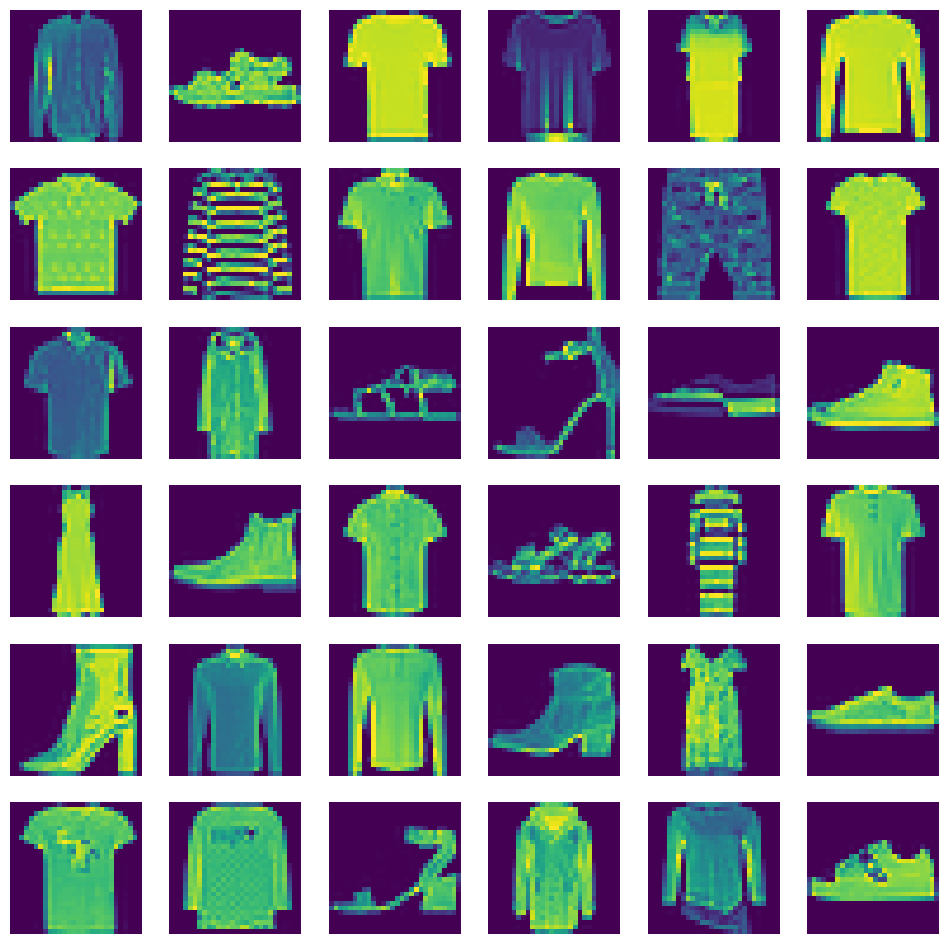

In [5]:
import matplotlib.pyplot as plt
import random
plot = train_images.reshape((-1, 28, 28))

np.random.shuffle(plot)

fig = plt.figure(figsize=(12,12))
for i in range(1,37):
    fig.add_subplot(6,6,i)
    plt.imshow(plot[i])
    plt.axis('off')

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [7]:
print(train_images.shape)

(60000, 28, 28, 1)


In [8]:
LATENT_DIM = 100
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 1

The Generator

In [9]:
def build_generator():
    model = Sequential(name="generator")

    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    return model

In [10]:
generator = build_generator()

The Discriminator

In [11]:
def build_discriminator(width, height, depth, alpha=0.2):
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same",
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model


In [12]:
discriminator = build_discriminator(28, 28, 1)

 Compiling th model

In [13]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            d_loss = (d_loss_real + d_loss_fake)/2

        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


In [14]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [15]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [16]:
LR = 0.0002

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Training the Model

Epoch 1/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6296 - g_loss: 0.8750

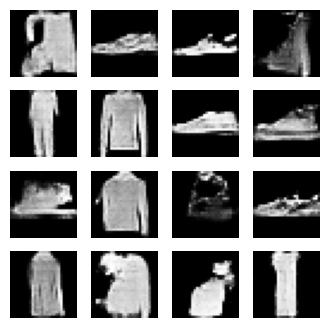

1875/1875 [==============================] - 35s 18ms/step - d_loss: 0.6297 - g_loss: 0.8750
Epoch 2/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6578 - g_loss: 0.8578

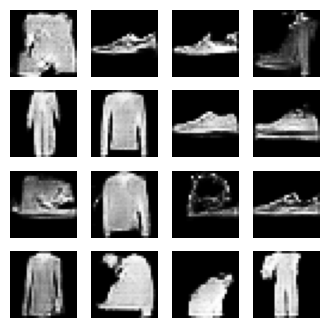

1875/1875 [==============================] - 35s 19ms/step - d_loss: 0.6578 - g_loss: 0.8580
Epoch 3/25
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6566 - g_loss: 0.8086

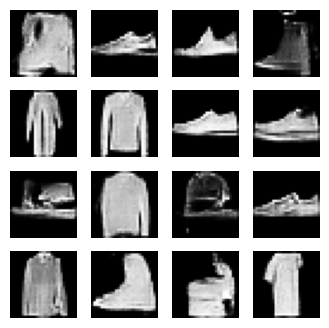

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6566 - g_loss: 0.8086
Epoch 4/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6659 - g_loss: 0.8061

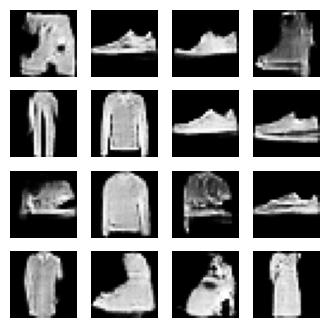

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6660 - g_loss: 0.8060
Epoch 5/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6690 - g_loss: 0.8074

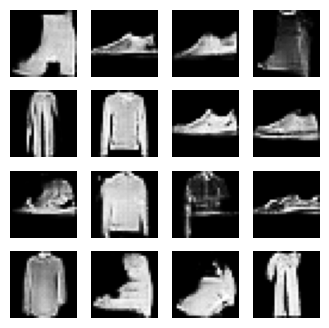

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6690 - g_loss: 0.8074
Epoch 6/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6705 - g_loss: 0.8158

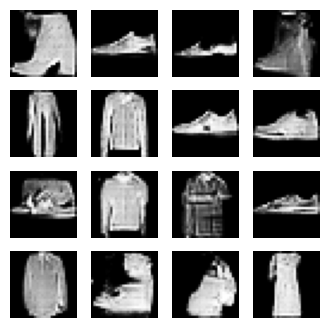

1875/1875 [==============================] - 33s 17ms/step - d_loss: 0.6705 - g_loss: 0.8159
Epoch 7/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6688 - g_loss: 0.7995

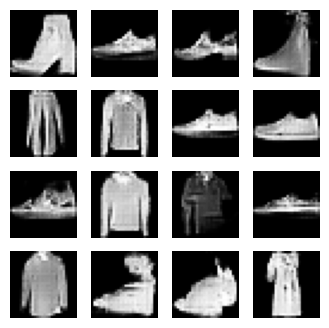

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6687 - g_loss: 0.7994
Epoch 8/25
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6703 - g_loss: 0.8080

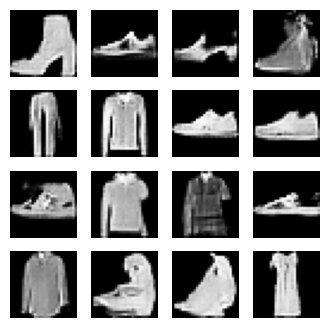

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6703 - g_loss: 0.8079
Epoch 9/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6712 - g_loss: 0.8014

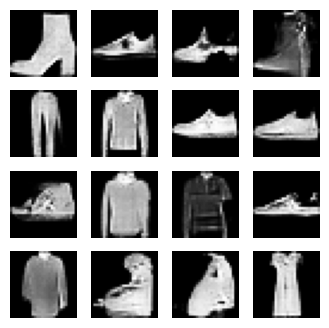

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6712 - g_loss: 0.8014
Epoch 10/25
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6707 - g_loss: 0.8074

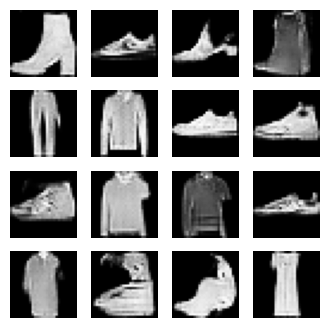

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6707 - g_loss: 0.8074
Epoch 11/25
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6691 - g_loss: 0.8011

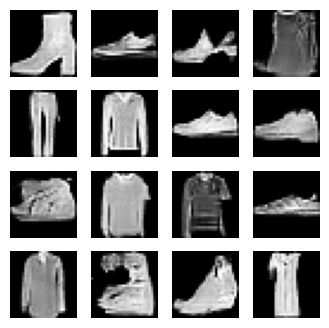

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6691 - g_loss: 0.8011
Epoch 12/25
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6718 - g_loss: 0.8034

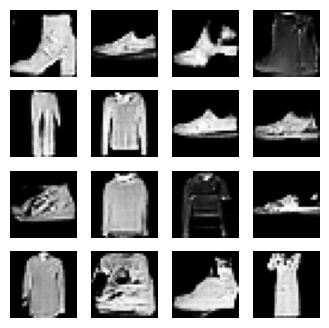

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6718 - g_loss: 0.8034
Epoch 13/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6709 - g_loss: 0.7956

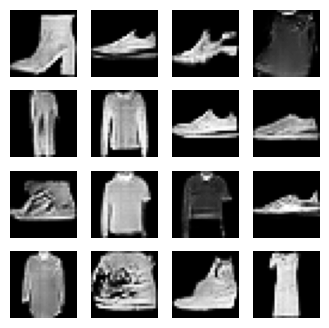

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6709 - g_loss: 0.7955
Epoch 14/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6704 - g_loss: 0.7934

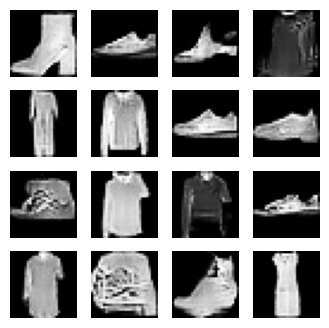

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6704 - g_loss: 0.7933
Epoch 15/25
1872/1875 [============================>.] - ETA: 0s - d_loss: 0.6713 - g_loss: 0.8010

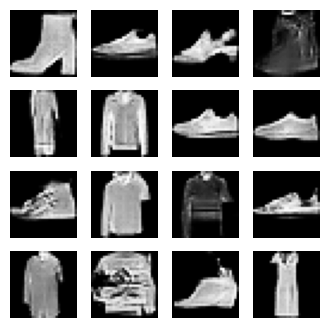

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6713 - g_loss: 0.8010
Epoch 16/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6702 - g_loss: 0.8002

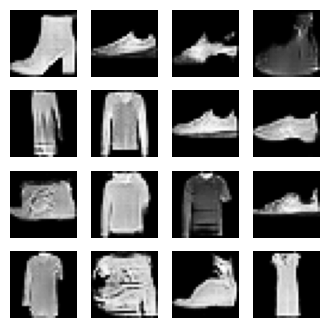

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6702 - g_loss: 0.8002
Epoch 17/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6696 - g_loss: 0.7960

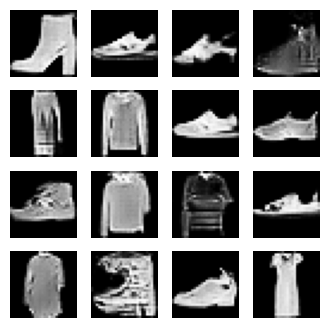

1875/1875 [==============================] - 32s 17ms/step - d_loss: 0.6696 - g_loss: 0.7960
Epoch 18/25
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6686 - g_loss: 0.7954

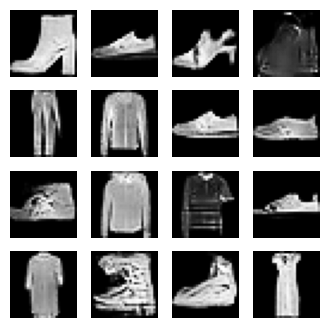

1875/1875 [==============================] - 36s 19ms/step - d_loss: 0.6686 - g_loss: 0.7954
Epoch 19/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6712 - g_loss: 0.8014

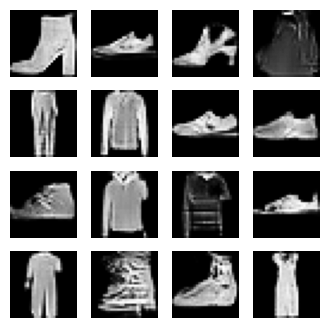

1875/1875 [==============================] - 33s 17ms/step - d_loss: 0.6712 - g_loss: 0.8014
Epoch 20/25
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6695 - g_loss: 0.7947

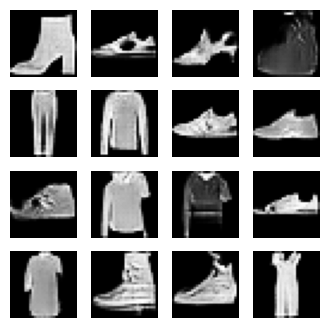

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6695 - g_loss: 0.7947
Epoch 21/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6700 - g_loss: 0.7964

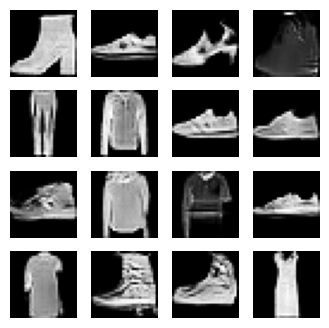

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6700 - g_loss: 0.7965
Epoch 22/25
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6709 - g_loss: 0.8003

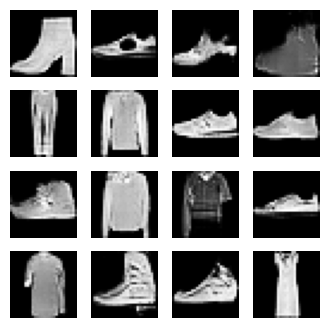

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6709 - g_loss: 0.8003
Epoch 23/25
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6715 - g_loss: 0.8038

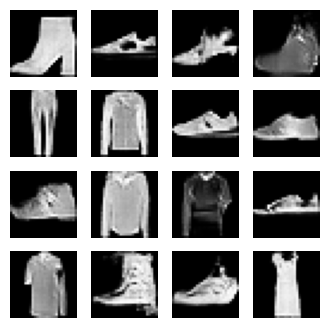

1875/1875 [==============================] - 33s 18ms/step - d_loss: 0.6715 - g_loss: 0.8038
Epoch 24/25
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6696 - g_loss: 0.7931

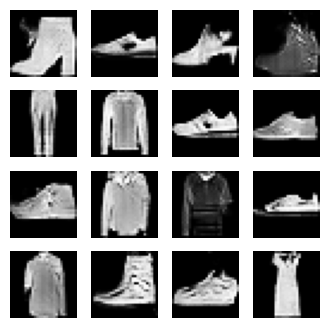

1875/1875 [==============================] - 33s 17ms/step - d_loss: 0.6696 - g_loss: 0.7933
Epoch 25/25
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6683 - g_loss: 0.8000

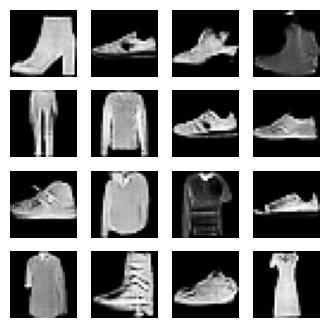

1875/1875 [==============================] - 34s 18ms/step - d_loss: 0.6683 - g_loss: 0.8000


In [18]:
NUM_EPOCHS = 25
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])